## Предисловие

Чтобы ```ffmpeg``` работал проще всего скачать собранную версию [link](https://ffmpeg.org/download.html) и скопировать ```ffmpeg.exe``` в папку с этим ноутбуком.
```ffmpeg``` нужен чтобы делать анимации.

Даунсемплинг\прореживание я написал сам, т.к. это просто оставляем каждое н-ое значение и такой функции в стандартных либах не нашел.

Порядок фильтров я брал дефолтный (```Defaults to 8 for ‘iir’ and 20 times the downsampling factor for ‘fir’.```), т.к. если брать 45 и 35 (в моем варианте), то результаты численно не стабильны и очень большие\маленькие (порядка $10^{20}$ и более).

In [39]:
from pathlib import Path

%matplotlib inline
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, signal
import pyaudio

In [40]:
N = 5 # number in group list, but doesn't really matter
k = 2 # key pressed
duration = 0.5 # in seconds
fs = 100_000

In [41]:
def tone(k: str, duration: float = 0.0075, fs: int = 100_000) -> np.ndarray:
    freqs = {
        "1": [697, 1209],
        "2": [697, 1336],
        "3": [697, 1477],
        "4": [770, 1209],
        "5": [770, 1336],
        "6": [770, 1477],
        "7": [852, 1209],
        "8": [852, 1336],
        "9": [852, 1477],
        "0": [941, 1336],
        "a": [697, 1633],
        "b": [770, 1633],
        "c": [852, 1633],
        "d": [941, 1633],
        "*": [941, 1209],
        "#": [941, 1477],
    }
    f = freqs[k]
    samples = np.mean(
        np.sin(np.outer(f, 2 * np.pi * np.arange(fs * duration) / fs)),
        axis=0)
    return samples

In [42]:
def downsample(x: np.array, q: int) -> np.array:
    """Keep each q-th element of array"""
    return x[::q]

In [43]:
def draw_plots(
        samples: list[list[float]],
        q: int,
        title: str = None,
        filename: str = None,
        labels: list[str] = ["Decimated FIR", "Decimated IIR", "Downsampled"],
        ) -> None:
    """Draw multiple plots on the same canvas. First plot is regular, rest are scatter."""
    # some magic to make plots look pretty
    t0 = np.arange(0, len(samples[1]) + 1, 1/q)[:len(samples[0])]
    t = np.arange(len(samples[1]))

    fig, ax = plt.subplots(dpi=200)
    ax.set_xlabel("Number of samples")
    ax.set_ylabel("Magnitude")
    ax.set_title(title)

    ax.plot(t0, samples[0], alpha=0.3, label="Original")

    for sample, label in zip(samples[1:], labels):
        ax.scatter(t, sample, s=2, alpha=0.7, label=label)
    ax.legend()
    if filename is not None:
        fig.savefig(f"img/{filename}.png")
    fig.show()

In [44]:
def draw_spectrums(
        samples: list[float],
        q_: int,
        title: str = None,
        filename: str = None,
        ) -> None:
    """Draw multiple spectrums on the same canvas."""
    fig, ax = plt.subplots(dpi=150)
    ax.set_xlabel("Frequncy, Hz")
    ax.set_ylabel("Magnitude")
    ax.set_title(title)

    for sample, q in zip(samples, q_):
        fs = 100_000 / q
        freqs = np.fft.fftfreq(len(sample), 1 / fs)
        ffts = np.abs(np.fft.fft(sample)) / len(sample)
        freqs, ffts = zip(*sorted(zip(freqs, ffts)))
        ax.plot(freqs, ffts, alpha=0.7, label=q)
    ax.legend(title="Factor")

    if filename is not None:
        fig.savefig(f"img/{filename}.png")

In [45]:
def play_tone(samples: np.ndarray, fs: int = 100_000) -> None:
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paFloat32, channels=1, rate=fs, output=True)
    stream.write(samples.astype(np.float32).tobytes())
    stream.stop_stream()
    stream.close()

#### Задание 1


##### Графики сигнала

C:\Users\Wicirelllis\AppData\Local\Temp\ipykernel_6356\9564828.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


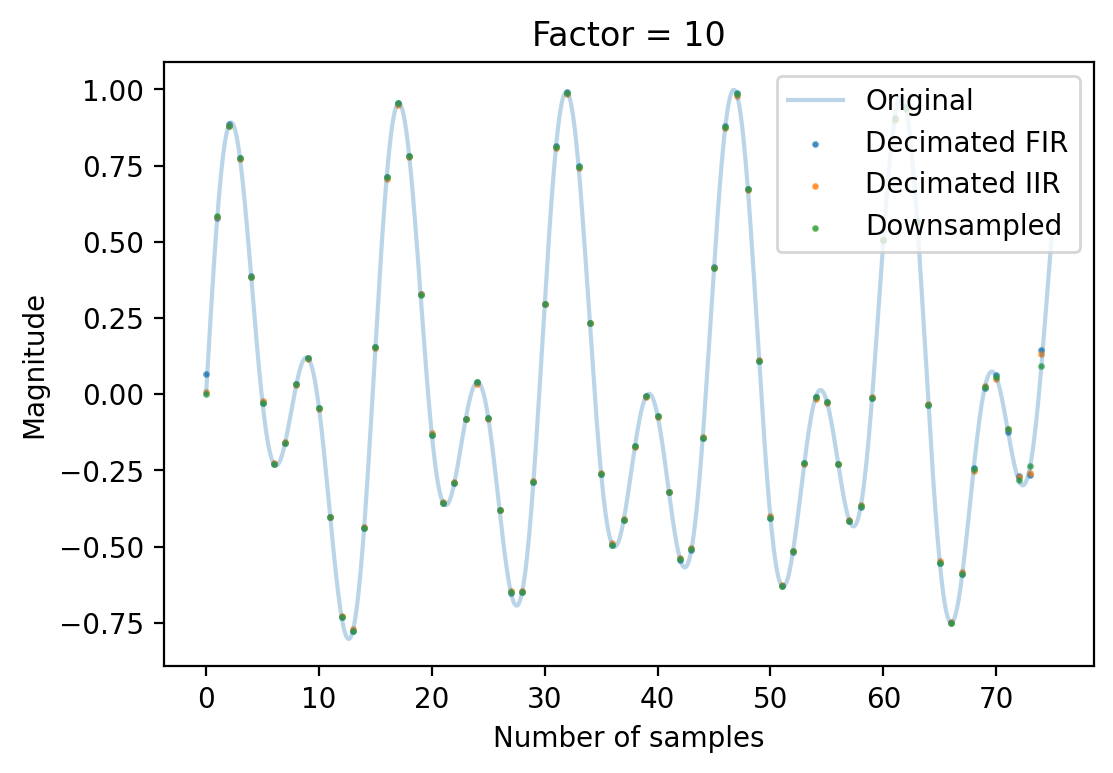

In [46]:
s = tone(str(k))
q = 10

decimated_fir = signal.decimate(s, q, ftype="fir")
decimated_iir = signal.decimate(s, q, ftype="iir")
downsampled = downsample(s, q)

draw_plots([s, decimated_fir, decimated_iir, downsampled], q, f"Factor = {q}")

C:\Users\Wicirelllis\AppData\Local\Temp\ipykernel_6356\9564828.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


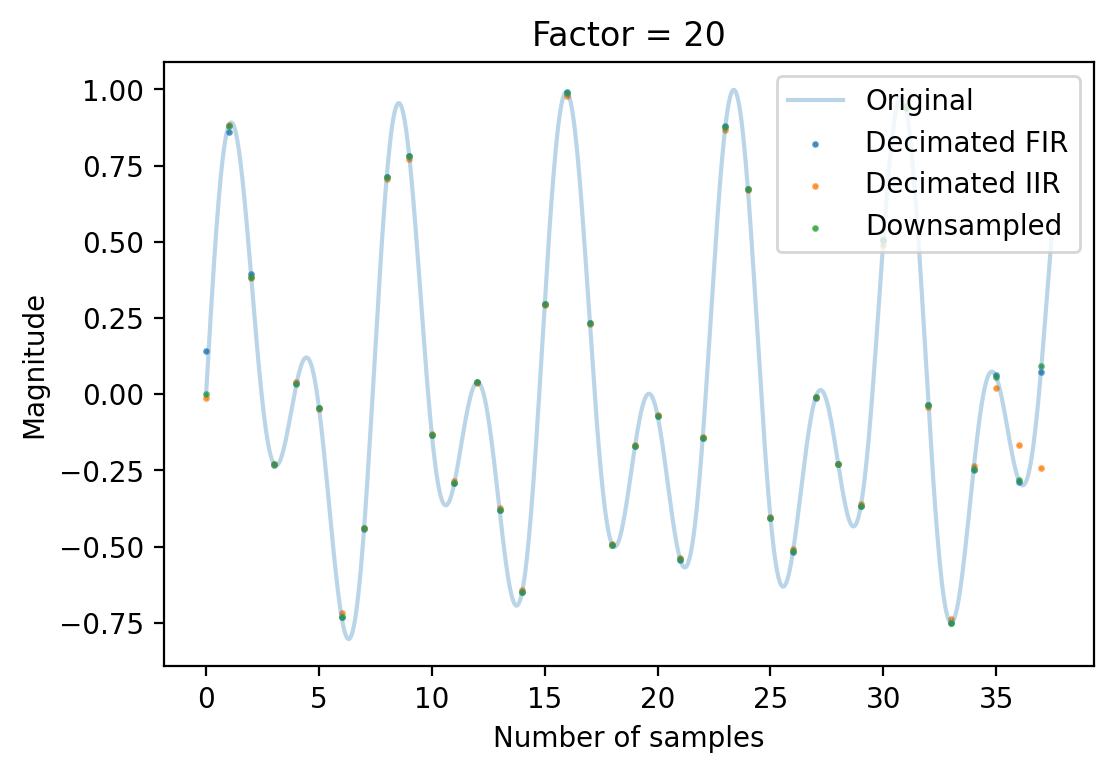

In [47]:
s = tone(str(k))
q = 20

decimated_fir = signal.decimate(s, q, ftype="fir")
decimated_iir = signal.decimate(s, q, ftype="iir")
downsampled = downsample(s, q)

draw_plots([s, decimated_fir, decimated_iir, downsampled], q, f"Factor = {q}")

C:\Users\Wicirelllis\AppData\Local\Temp\ipykernel_6356\9564828.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


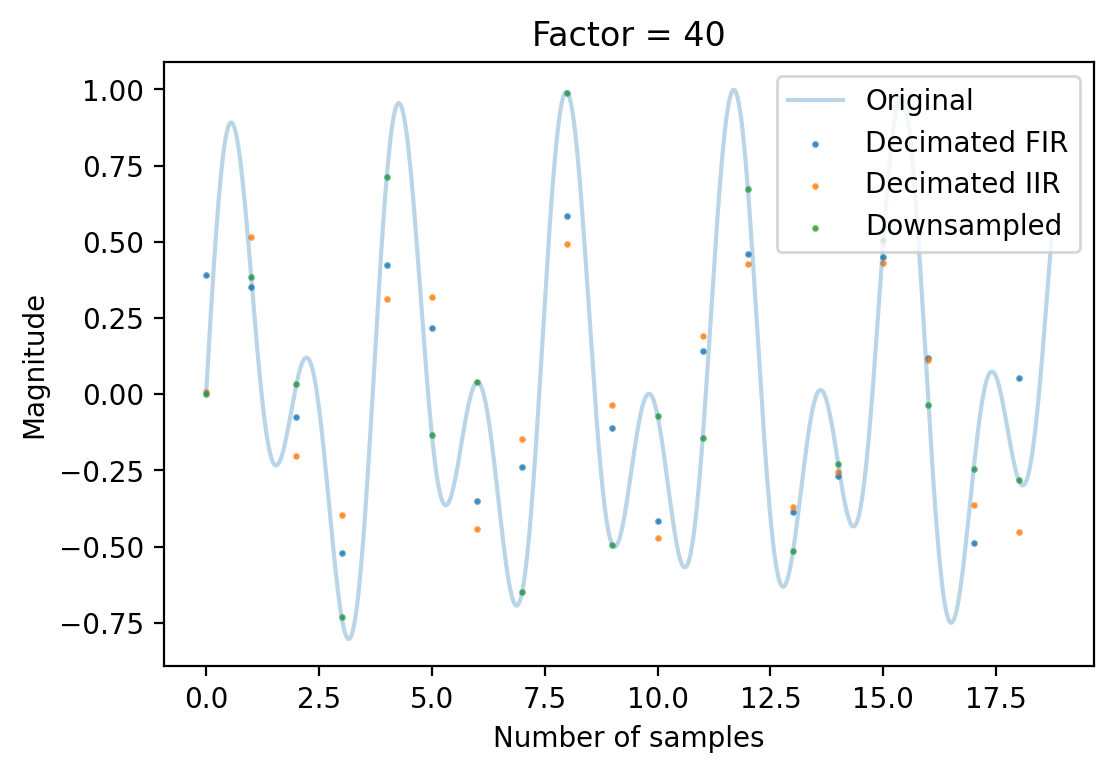

In [48]:
s = tone(str(k))
q = 40

decimated_fir = signal.decimate(s, q, ftype="fir")
decimated_iir = signal.decimate(s, q, ftype="iir")
downsampled = downsample(s, q)

draw_plots([s, decimated_fir, decimated_iir, downsampled], q, f"Factor = {q}")

##### Спектр

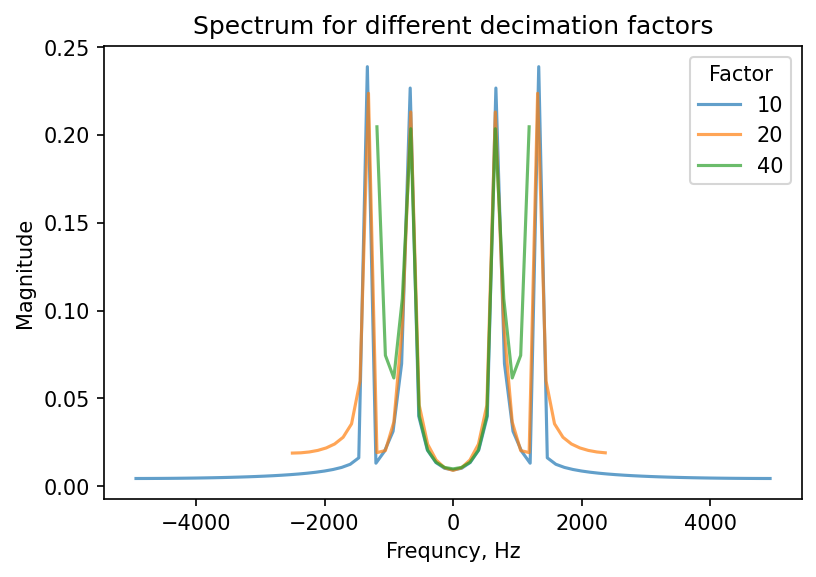

In [49]:
samples = []
q = []
for q_ in [10, 20, 40]:
    samples.append(downsample(s, q_))
    q.append(q_)
draw_spectrums(samples, q, "Spectrum for different decimation factors")
# samples

##### Звук

Я беру сигнал длиной в 0.5с, прорежаю его, потом интерполирую и сравниваю звучание.

На слух прореженный сигнал и оригинал не отличаются при небольших коэф. выброса из-за того, что иначальная частота дискретизации очень высокая. Например при ```q=10``` частота дискретизации падает до 10кГц, но даже этого более чем достаточно, т.к. синусы в сигнале не выше пары кГц.
Но при ```q=40``` отличие уже заметно.

In [50]:
s = tone(str(k), 0.5)

In [51]:
# original
play_tone(s)

In [52]:
# factor 10, downsample + interpolation
# sounds a bit off
q = 10
downsampled = downsample(s, q)
interpolate_func = interpolate.UnivariateSpline(np.arange(0, len(s), q)[:len(downsampled)], downsampled, s=5)
downsampled_interpolated = interpolate_func(np.arange(0, len(s)))
# normalize bc it sounds better this way. idk the reason
downsampled_interpolated /= np.max(downsampled_interpolated)
play_tone(downsampled_interpolated)

In [53]:
# factor 10, just downsample
# sounds exactly as original
play_tone(downsampled, fs // q)

In [54]:
# factor 20, downsample + interpolation
# even further from original compared to q=10, some clicking (?) in background
q = 20
downsampled = downsample(s, q)
interpolate_func = interpolate.UnivariateSpline(np.arange(0, len(s), q)[:len(downsampled)], downsampled, s=5)
downsampled_interpolated = interpolate_func(np.arange(0, len(s)))
downsampled_interpolated /= np.max(downsampled_interpolated)
play_tone(downsampled_interpolated)

In [55]:
# factor 20, just downsample
# sounds very slightly different compared to original
play_tone(downsampled, fs // q)

In [56]:
# factor 40, downsample + interpolation
q = 40
downsampled = downsample(s, q)
interpolate_func = interpolate.UnivariateSpline(np.arange(0, len(s), q)[:len(downsampled)], downsampled, s=5)
downsampled_interpolated = interpolate_func(np.arange(0, len(s)))
play_tone(downsampled_interpolated)

In [57]:
# factor 40, just downsample
# noticeable difference from original
play_tone(downsampled, fs // q)

#### Задание 2

Анимированный график прореженого сигнала в зависимости от коэффициента выброса значений.

In [58]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

plt.rcParams['animation.ffmpeg_path'] = "ffmpeg.exe"

s = tone(str(k))
t = np.arange(0, len(s))

fig, ax = plt.subplots(dpi=200)
ax.plot(t, s, alpha=0.3)
sct = ax.scatter([], [], s=2, c="r", label=" ")
l = ax.legend(title="Factor")

def frame(q: int):
    ss = downsample(s, q)
    tss = np.arange(0, len(s), q)
    sct.set_offsets(np.array([tss, ss]).T)
    l.get_texts()[0].set_text(q)
    return sct

anim = FuncAnimation(fig, frame, range(1, 50), interval=1_000)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

<IPython.core.display.Javascript object>

#### Задание 3

Анимированный график спектров прореженого и децимированного сигналов в зависимости от коэффициента выброса значений.

In [62]:
s = tone(str(k), 0.5)
t = np.arange(0, len(s))

fs = 100_000
freqs = np.fft.fftfreq(len(s), 1 / fs)
ffts = np.abs(np.fft.fft(s)) / len(s)
freqs, ffts = zip(*sorted(zip(freqs, ffts)))

fig, ax = plt.subplots(dpi=200)
ax.set_xlim(-5000, 5000)
ax.plot(freqs, ffts, alpha=0.2, label="Original")
lines = []
lines.append(ax.plot([], c="r", alpha=0.2, label=" ")[0])
lines.append(ax.plot([], c="g", alpha=0.2, label=" ")[0])

l = ax.legend(title="Factor")

def frame(q: int):
    fs = 100_000 / q

    downsampled = downsample(s, q)
    freqs = np.fft.fftfreq(len(downsampled), 1 / fs)
    ffts = np.abs(np.fft.fft(downsampled)) / len(downsampled)
    freqs, ffts = zip(*sorted(zip(freqs, ffts)))
    lines[0].set_data([freqs, ffts])
    l.get_texts()[1].set_text(f"Downsampled, {q}")

    decimated = signal.decimate(s, q, ftype="iir")
    freqs = np.fft.fftfreq(len(decimated), 1 / fs)
    ffts = np.abs(np.fft.fft(decimated)) / len(decimated)
    freqs, ffts = zip(*sorted(zip(freqs, ffts)))
    lines[1].set_data([freqs, ffts])
    l.get_texts()[2].set_text(f"Decimated, {q}")

    return sct

anim = FuncAnimation(fig, frame, range(1, 50), interval=1_000)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

<IPython.core.display.Javascript object>

#### Задание 4

Анимированный график интерполяции прореженого и децимированного сигналов в зависимости от коэффициента выброса значений.

Можно видеть, что интерполяция работает так себе (особенно при $q>5$, но может быть, если покрутить параметры сплайна, то будет лучше).

In [64]:
# abandon hope all ye who enter here
fs = 100_000

fig, ax = plt.subplots(dpi=200)
s = tone(str(k))
t = np.arange(0, len(s))
ax.plot(t, s, alpha=0.5, label="Original")
lines = []
lines.append(ax.plot([], "-o", lw=0.5, c="g", alpha=0.3, markersize=1, label=" ")[0])
lines.append(ax.plot([], "-o", lw=0.5, c="r", alpha=0.3, markersize=1, label=" ")[0])

l = ax.legend(title="Factor")

def frame(q: int):
    fs = 100_000 / q

    downsampled = downsample(s, q)
    interpolate_func = interpolate.UnivariateSpline(np.arange(0, len(s), q)[:len(downsampled)], downsampled, s=1)
    downsampled_interpolated = interpolate_func(np.arange(0, len(s)))
    t = np.arange(len(s))
    lines[0].set_data([t, downsampled_interpolated])
    l.get_texts()[1].set_text(f"Downsampled, {q}")

    decimated = signal.decimate(s, q, ftype="iir")
    interpolate_func = interpolate.UnivariateSpline(np.arange(0, len(s), q)[:len(decimated)], decimated, s=1)
    decimated_interpolated = interpolate_func(np.arange(0, len(s)))
    t = np.arange(len(s))
    lines[1].set_data([t, decimated_interpolated])
    l.get_texts()[2].set_text(f"Decimated, {q}")

    return sct

anim = FuncAnimation(fig, frame, range(1, 50), interval=1_000)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

<IPython.core.display.Javascript object>